# Lab 4: Subgradients

## Imports, Optimizer & Plotting
This section defines imports, the subgradient decent optimizer that will use, along with supporting plotting code.

In [370]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

#%matplotlib notebook
%matplotlib inline

def subgradient_descent(x0,f,g,args=[],alpha=1,maxIter=100,tol=1e-4,callback=None):
    '''
    Args:
        x0: Starting value for optimizer. Shape (D,1)
        f: Objective functions. Accepts input of shape (D,1)
        g: Subgradient function for f. Accepts input of shape (D,1)
        alpha: Starting step size
        maxIter: Maximum number of optimization iterations
        tol: Convergence tolerance. 
        callback: Called after each iteration with current x and f(x) values

    Returns:
        Tuple consisting of (xbest,fbest), the best value of x found and the value of f(xbest)
     
    '''
    D     = x0.shape[0]
    fbest = np.inf
    flast = None
    xbest = x0
    x     = x0

    for i in range(maxIter - 1):
        gi = g(x,*args)
        alpha_i = (alpha / (1 + np.sqrt(i))) / (1+np.sqrt(np.sum(gi**2)))
        x  = x - alpha_i * gi
        fi  = f(x,*args)

        if(callback is not None):
            callback(x,fi)

        if fi < fbest:
            xbest = x
            fbest = fi

        if(i%(maxIter//10)==0): print(f"Iteration {i}: obj: {fi:.4f}")

        if flast is not None and  abs(fi - flast) / (1e-8+abs(flast)) < tol: break
        flast = fi


    return(xbest, fbest)

## Question 1: Loss Function Implementation
This section defines the regression loss function $\ell_{\epsilon}(r)$ that we'll use for this exercise in terms of the residual $r_n=y_n-f_{\theta}(\mathbf{x}_n)$. Your first task is to implement this loss function. Your implementation should be vectorized so that it takes a column vector of residuals as input and produces a column vector of loss values as output. The function is defined as follows:

$$\ell_{\epsilon}(r) = \max(0, r^2-\epsilon^2)$$

In [306]:
def l(r,eps):
    out = np.maximum(0, r**2-eps**2)
    return out

Once you have the loss function implemented, run the code below to plot the loss function. 

Text(0.5, 1.0, 'Loss Function Plot (eps=2)')

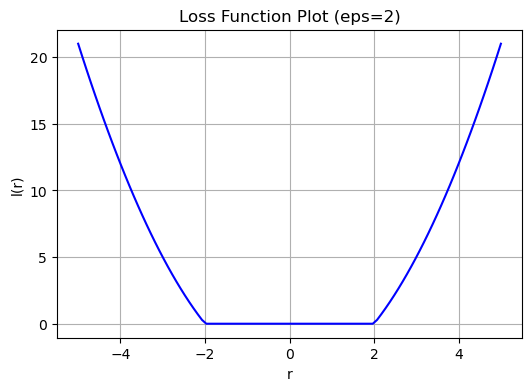

In [307]:
plt.figure(figsize=(6,4))
r = np.linspace(-5,5,100).reshape(-1,1)
lr = l(r,2)
plt.plot(r,lr,"b-")
plt.grid(True)
plt.xlabel("r")
plt.ylabel("l(r)")
plt.title("Loss Function Plot (eps=2)")

## Question 2: Convexity
Using properties of convex functions, prove that this loss function is convex.

## Question 3: Subgradient
Derive a subgradient function $\ell'_{\epsilon}(r)$ for the loss function $\ell_{\epsilon}(r)$. If the subdifferential is not a singleton set for a given value of $r$ and $0$ is in the sub-differential at $r$, use $0$ as the subgradient value.

## Question 4: Sub-gradient Implementation
Implement your sub-gradient function $\ell'_{\epsilon}(r)$, then use the supplied code to plot it. Your implementation must accept a column vector of residual values as input and produce a corresponding column vector of sub-gradient values as output. 

In [308]:
def lprime(r,eps):
    out = 2*r
    out[np.abs(r)<=eps]=0
    return out

Once you have the loss function implemented, run the code below to plot the loss function. 

Text(0.5, 1.0, 'Loss Sub-gradient Function (eps=2)')

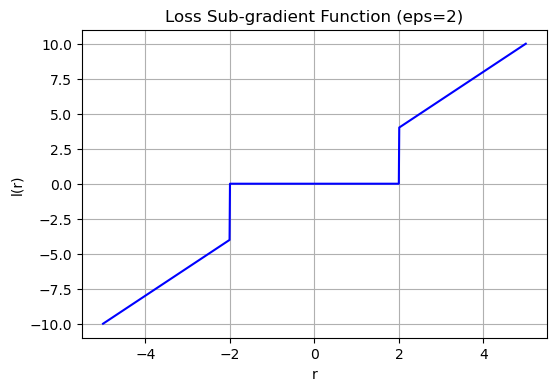

In [309]:
plt.figure(figsize=(6,4))
r = np.linspace(-5,5,1000).reshape(-1,1)
plt.plot(r,lprime(r,2),"b-")
plt.grid(True)
plt.xlabel("r")
plt.ylabel("l(r)")
plt.title("Loss Sub-gradient Function (eps=2)")

## Question 5: Regularized Risk
We are now going to learn a linear regression model using this loss function. We will use a regularized risk with the squared two norm regularizer as shown below. You need to implement the regularized risk function. It must take as input an array of parameter values $\theta=[\mathbf{w};b]$ of shape (D+1,1), an array of bias absorbed inputs $X$ of shape (N,D+1), an array of outputs $Y$ of shape (N,1), and a value of the regularization parameter $\lambda$. The implementation should be vectorized and should call your implementation of the loss function $\ell_{\epsilon}(r)$.
$$R(\theta,D) = \frac{1}{N}\sum_{n=1}^N \ell_{\epsilon}(y_n-\mathbf{x}_n\theta) + \lambda \Vert\mathbf{w}\Vert_2^2$$

In [420]:
def regularized_risk(theta, X, Y, eps,lam):
    r   = Y - X@theta
    out = np.mean(l(r,eps)) + 2*lam*np.sum(theta[:-1,0]**2)
    return out

## Question 6: Regularized Risk Sub-Gradient
The final component we need to learn the model is a regularized risk sub-gradient function. For this problem, the regularized risk sub-gradient is given by the expression below. You next need to implement this function. It must take as input an array of parameter values $\theta=[\mathbf{w};0]$ of shape (D+1,1), an array of bias absorbed inputs $X$ of shape (N,D+1), an array of outputs $Y$ of shape (N,1), and a value of the regularization parameter $\lambda$. The implementation should be vectorized and should call your implementation of the loss subgradiejt function $\ell'_{\epsilon}(r)$.

$$-\frac{1}{N}\sum_{n=1}^N \ell'_{\epsilon}(y_n-\mathbf{x}_n\theta)\mathbf{x}_n^T + 2\lambda[\mathbf{w};0]$$



In [421]:
def regularized_risk_gradient(theta, X, Y, eps,lam):
    r   = Y - X@theta
    out = -1*np.mean(lprime(r,eps)*X,axis=0,keepdims=True).T + 2*lam*np.vstack([theta[:-1,[0]],np.zeros((1,1))])
    return out

## Question 7: Learning
We are now going to apply the sub-gradient descent learning procedure to learn the model using your regularized risk and sub-gradient functions. First, we'll construct a synthetic data set.

Text(0.5, 1.0, 'Data Set')

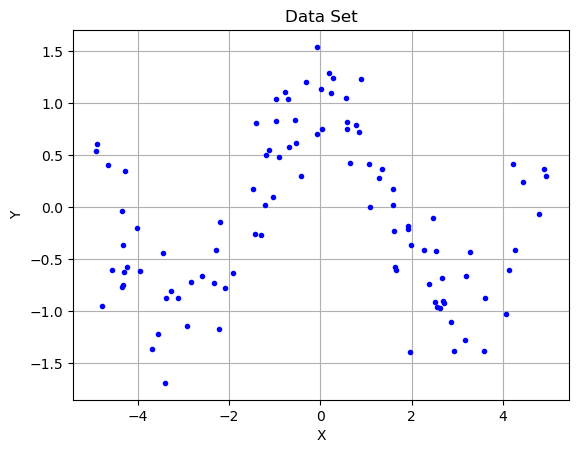

In [422]:
N = 100
B = 2
X = 10*(np.random.rand(N,1)-0.5)
Y = np.cos(X) +  np.random.randn(N,1)/3
plt.plot(X,Y,"b.")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.title("Data Set")


We will learn the model using a polynomial basis expansion of order 5. We define some helper functions below to perform the basis expansion, standardize the data and apply bias absorption.

In [438]:
def phi(X,B):
    return X**np.arange(1,B+1)

def standardize(X,m=None,s=None):
    if m is None:
        m=X.mean(axis=0)
    if s is None:
        s=X.std(axis=0)
    return (X-m)/s, m, s

def bias_absorb(X):
    return np.hstack([X, np.ones((X.shape[0],1))])

def featurize(X,B,m=None,s=None):
    XB = phi(X,B)
    XB,m,s  = standardize(XB,m,s)
    XB =  bias_absorb(XB)
    return XB,m,s

B       = 5
XB,m,s  = featurize(X,B)

Now, we will run the optimizer and plot the results. We start with $\epsilon=0$, which results in a special case of the loss function that is equivalent to OLS. Leaving the other parameters as is, try increasing the value of $\epsilon$. Explain what happens to the prediction function as $\epsilon$ is increased. 

Iteration 0: obj: 0.6178
Iteration 100: obj: 0.2945
Iteration 200: obj: 0.2924
Iteration 300: obj: 0.2951
Iteration 400: obj: 0.2972
Iteration 500: obj: 0.2987
Iteration 600: obj: 0.2996
Iteration 700: obj: 0.3002
Iteration 800: obj: 0.3006
Iteration 900: obj: 0.3008


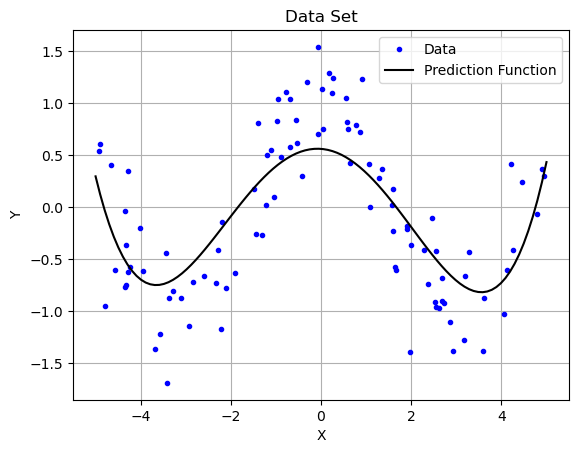

In [439]:
eps     = 0
lam     = 0.01
theta0 = np.zeros((B+1,1))
theta_star, R_star = subgradient_descent(theta0,regularized_risk,regularized_risk_gradient,[XB,Y,eps,lam],tol=1e-8,maxIter=1000,alpha=1)

N = 100
XT  = np.linspace(-5,5,100).reshape(100,1)
XBT,_,_ = featurize(XT,B,m,s)
YT = XBT@theta_star
plt.plot(X,Y,"b.")
plt.plot(XT[:,0],YT,"k-")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.title("Data Set")
plt.legend(["Data","Prediction Function"])